# Classificação Binária:
***

Classificação é um tipo de problema de machine learning supervisionado, em que treinamos um modelo usando features(variáveis independentes) para predizer uma variável dependente(label), que calcula a probabilidade de que os casos observados, pertençam a uma das classes possíveis. No caso da classificação binária só há dois casos possíveis, "Sim" ou "Nao", "Falso" ou "Verdadeiro". No presente problema do Titanic, queremos prever, se um passageiro X, "Sobreviveu" - 1, ou "Não Sobreviveu" - 0. 

In [1]:
import os
import pandas as pd
import numpy as np

SRC_DIR = os.path.abspath(".")         # endereço do script
BASE_DIR = os.path.dirname(SRC_DIR)
DATA_DIR = os.path.join(BASE_DIR, "data")
IMGS_DIR = os.path.join(BASE_DIR, "images")

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import category_encoders as ce
import warnings
warnings.filterwarnings("ignore")
from sklearn import set_config
set_config(display = 'diagram')

pd.options.display.max_columns = 200
pd.options.display.max_rows = 999
pd.set_option("precision", 3)

In [2]:
df=pd.read_csv(os.path.join(DATA_DIR, "train.csv"))
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.050,NaN,S


Dropando as features que não serão usadas na construção do modelo:

**PassengerId, Name, Ticket, Cabin**

## Vamos separar as features e os labels:

In [3]:
dropar = ['PassengerId','Cabin', 'Ticket', 'Name']
df.drop(dropar, axis = 1, inplace=True)

In [4]:
df.sample(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
833,0,3,male,23.0,0,0,7.854,S
59,0,3,male,11.0,5,2,46.900,S
391,1,3,male,21.0,0,0,7.796,S
528,0,3,male,39.0,0,0,7.925,S
701,1,1,male,35.0,0,0,26.288,S
599,1,1,male,49.0,1,0,56.929,C
585,1,1,female,18.0,0,2,79.650,S
857,1,1,male,51.0,0,0,26.550,S
194,1,1,female,44.0,0,0,27.721,C
488,0,3,male,30.0,0,0,8.050,S


In [5]:
features = df.drop('Survived', axis=1).columns.tolist()
display(features)
label="Survived"
display(label)

X, y = df[features].values, df[label].values

for n in range(0, 4):
    print("Passageiro", str(n+1), "\n Features:", list(X[n]), "\n Label:", y[n])

['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']

'Survived'

Passageiro 1 
 Features: [3, 'male', 22.0, 1, 0, 7.25, 'S'] 
 Label: 0
Passageiro 2 
 Features: [1, 'female', 38.0, 1, 0, 71.2833, 'C'] 
 Label: 1
Passageiro 3 
 Features: [3, 'female', 26.0, 0, 0, 7.925, 'S'] 
 Label: 1
Passageiro 4 
 Features: [1, 'female', 35.0, 1, 0, 53.1, 'S'] 
 Label: 1


### Análise descritiva
***

In [6]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000,891.000,714.000,891.000,891.000,891.000
mean,0.384,2.309,29.699,0.523,0.382,32.204
std,0.487,0.836,14.526,1.103,0.806,49.693
min,0.000,1.000,0.420,0.000,0.000,0.000
25%,0.000,2.000,20.125,0.000,0.000,7.910
50%,0.000,3.000,28.000,0.000,0.000,14.454
75%,1.000,3.000,38.000,1.000,0.000,31.000
max,1.000,3.000,80.000,8.000,6.000,512.329


Podemos ver que das features numéricas, temos a variável "Age" com dados, faltantes. A taxa de sobrevivencia nesse conjunto de dados é de 38%.

In [7]:
# Variáveis categóricas
df.describe(include='O')

,Sex,Embarked
count,891,889
unique,2,3
top,male,S
freq,577,644


A variável "Embarked" =  que é o porto aonde o passageiro embarcou, também tem 2 dados, faltantes, o que podemos preencher com a moda dessa variável categórica.

In [8]:
df.fillna({"Embarked":"S"}, inplace=True)

### Preenchendo os dados faltantes da variável com uma idade determinada por um modelo de machine learning, a partir dos outros dados.

In [9]:
df_age=df[~df['Age'].isna()].copy()
df_age.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  714 non-null    int64  
 1   Pclass    714 non-null    int64  
 2   Sex       714 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     714 non-null    int64  
 5   Parch     714 non-null    int64  
 6   Fare      714 non-null    float64
 7   Embarked  714 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 50.2+ KB


Construindo uma árvore de decisão com apenas as features numéricas.

In [10]:
from sklearn.tree import DecisionTreeRegressor
features_age = df_age.select_dtypes(include=['int', 'float']).drop('Age', axis=1).columns
features_age

Index(['Survived', 'Pclass', 'SibSp', 'Parch', 'Fare'], dtype='object')

In [11]:
tree_reg_age=DecisionTreeRegressor(max_depth=3, random_state=123)  # instanciando um decision tree regressor para calcular as idades faltantes
tree_reg_age.fit(df_age[features_age], df_age['Age'])
df['AgePredicted'] = tree_reg_age.predict(df[features_age])


def input_age(row):
    if np.isnan(row['Age']):
        return row['AgePredicted']
    else:
        return row['Age']


df["Age"]= df[["Age", "AgePredicted"]].apply(input_age, axis=1)


df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Survived      891 non-null    int64  
 1   Pclass        891 non-null    int64  
 2   Sex           891 non-null    object 
 3   Age           891 non-null    float64
 4   SibSp         891 non-null    int64  
 5   Parch         891 non-null    int64  
 6   Fare          891 non-null    float64
 7   Embarked      891 non-null    object 
 8   AgePredicted  891 non-null    float64
dtypes: float64(3), int64(4), object(2)
memory usage: 62.8+ KB


In [12]:
df.drop('AgePredicted', axis=1, inplace=True)
df.dtypes

Survived      int64
Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked     object
dtype: object

In [13]:
df.Pclass=df.Pclass.astype('category')
df.Sex=df.Sex.astype('category')
df.Embarked = df.Embarked.astype('category')

Nova feature juntando as informações, das variáveis SibSp e Parch: **family_size**

In [14]:
df['family_size'] = df.SibSp + df.Parch + 1

In [15]:
df.isna().sum()

Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
family_size    0
dtype: int64

In [16]:
features

['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']

In [17]:
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked',
'family_size']

label = 'Survived'

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Survived     891 non-null    int64   
 1   Pclass       891 non-null    category
 2   Sex          891 non-null    category
 3   Age          891 non-null    float64 
 4   SibSp        891 non-null    int64   
 5   Parch        891 non-null    int64   
 6   Fare         891 non-null    float64 
 7   Embarked     891 non-null    category
 8   family_size  891 non-null    int64   
dtypes: category(3), float64(2), int64(4)
memory usage: 44.9 KB


In [19]:
import seaborn as sns

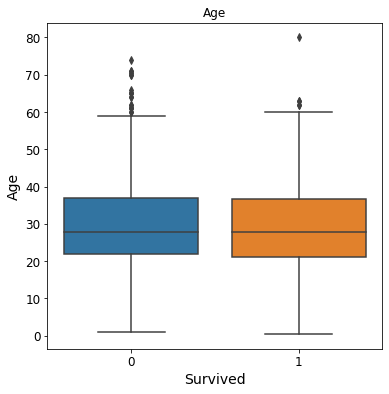

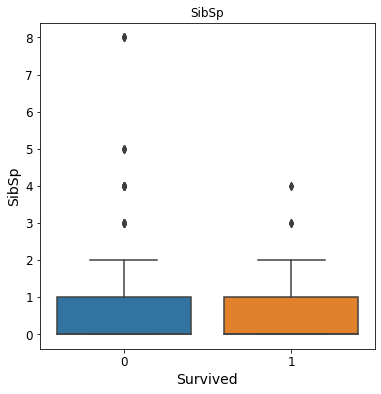

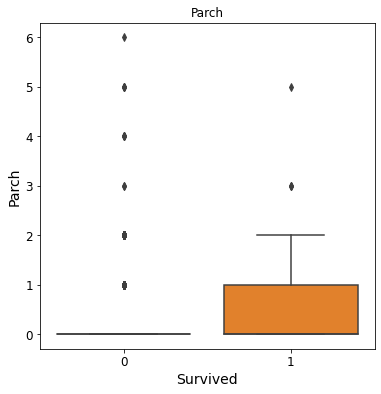

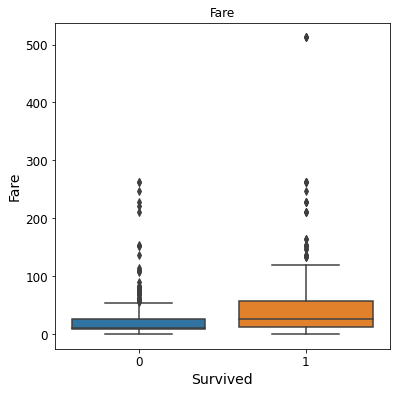

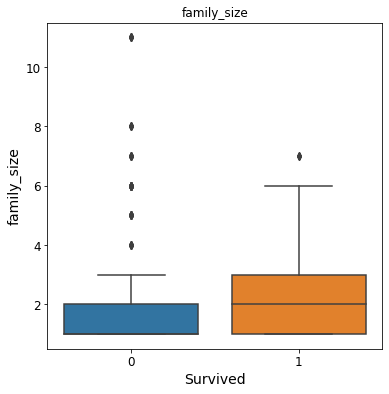

In [20]:
features_numericas = ['Age', 'SibSp', 'Parch', 'Fare', 'family_size']
for col in features_numericas:
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.boxplot(x='Survived', y = col, data = df, ax = ax)
    plt.title(col)
plt.show()

<AxesSubplot:title={'center':'Classes de viagem'}>

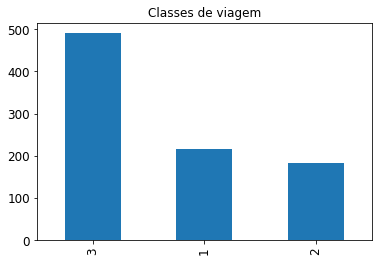

In [21]:
plt.title('Classes de viagem')
df['Pclass'].value_counts().plot(kind='bar')

<AxesSubplot:ylabel='Survived'>

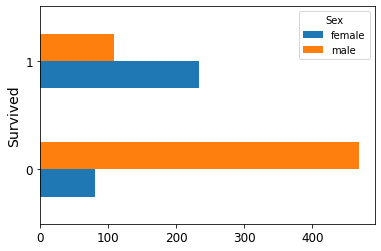

In [22]:
df.groupby('Sex')['Survived'].value_counts().unstack(0).plot.barh()

<AxesSubplot:xlabel='Survived'>

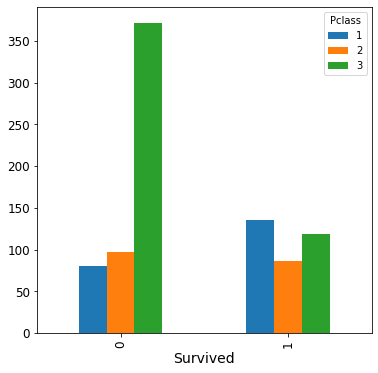

In [23]:
df.groupby('Pclass')['Survived'].value_counts().unstack(0).plot.bar(figsize=(6, 6))

In [24]:
pivot_class_gender_survived = pd.pivot_table(df,
                                             values = ['Survived'], 
                                             index = 'Pclass', 
                                             columns='Sex',
                                             aggfunc=['mean', 'count'])

pivot_class_gender_survived

mean           count     
       Survived        Survived     
Sex      female   male   female male
Pclass                              
1         0.968  0.369       94  122
2         0.921  0.157       76  108
3         0.500  0.135      144  347

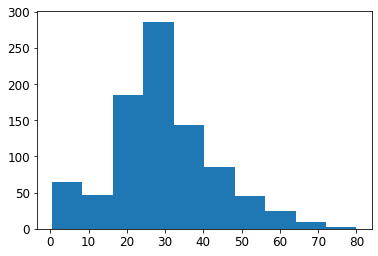

In [25]:
plt.hist(x = df['Age']);

In [26]:
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked',
'family_size']

label = 'Survived'
X=df[['Pclass','Age', 'SibSp', 'Parch', 'Fare','family_size']]
y = df[['Survived']]

In [27]:
from sklearn.model_selection import train_test_split

# Split data 70%-20% into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

print ('Training cases: %d\nTest cases: %d' % (X_train.shape[0], X_test.shape[0]))

Training cases: 712
Test cases: 179


## Treinamento e avaliação de um classificador binário
***

In [28]:
from sklearn.linear_model import LogisticRegression
logistic_model = LogisticRegression(penalty='l2', C=1.0, solver='liblinear').fit(X_train, y_train)
print(logistic_model)

LogisticRegression(solver='liblinear')


In [30]:
predictions = logistic_model.predict(X_test)
print('Predicted labels: ', predictions[:10])
print('Actual labels:    ' ,y_test[:10])

Predicted labels:  [0 0 0 1 0 1 1 1 1 0]
Actual labels:          Survived
495         0
648         0
278         0
31          1
255         1
298         1
609         1
318         1
484         1
367         1


In [33]:
from sklearn.metrics import accuracy_score
print('Qual a proporção dos labels foram corretamente previstas pelo modelo')
print('Accuracy: ', accuracy_score(y_test, predictions))
accuracy = accuracy_score(y_test, predictions)
print(f'Quantos amostras foram previstas corretamente--> {accuracy*100:.2f}%')

Qual a proporção dos labels foram corretamente previstas pelo modelo
Accuracy:  0.7486033519553073
Quantos amostras foram previstas corretamente--> 74.86%


In [34]:
from sklearn. metrics import classification_report

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.74      0.90      0.81       110
           1       0.76      0.51      0.61        69

    accuracy                           0.75       179
   macro avg       0.75      0.70      0.71       179
weighted avg       0.75      0.75      0.74       179



A tabela acima contém as seguintes informações: A classification report includes the following metrics for each class (0: 'not survived', 1: 'survived')

* **Acurácia**: Qtos predições o modelo previu corretamente ?
* **Precisão**: Dos passageiros que o modelo previu que sobrevivesse, realmente sobreviveu?
* **Recall**: Do total de reais sobreviventes, o modelo corretamente previu a sobrevivência.
* **F1-Score**:Um métrica média que leva em conta precisão e recall.

Como esse é um problema de classificação binária, a classe 1 (*Survived*) é considerada positiva e sua precisão e recall são particularmente interessantes.

* De todos os passageiros que o modelo previu que sobreviveram, quantos sobreviveram de fato?
* De todos os passageiros que sobreviveram de fato, quantos o modelo identificou corretamente ?

In [35]:
from sklearn.metrics import precision_score, recall_score

print("Overall Precision:",precision_score(y_test, predictions))
print("Overall Recall:",recall_score(y_test, predictions))

Overall Precision: 0.7608695652173914
Overall Recall: 0.5072463768115942


he precision and recall metrics are derived from four possible prediction outcomes:
* *True Positives*: The predicted label and the actual label are both 1.
* *False Positives*: The predicted label is 1, but the actual label is 0.
* *False Negatives*: The predicted label is 0, but the actual label is 1.
* *True Negatives*: The predicted label and the actual label are both 0.

These metrics are generally tabulated for the test set and shown together as a *confusion matrix*, which takes the following form:

In [36]:
from sklearn.metrics import confusion_matrix

# Print the confusion matrix
cm = confusion_matrix(y_test, predictions)
print (cm)

[[99 11]
 [34 35]]


Until now, we've considered the predictions from the model as being either 1 or 0 class labels. Actually, things are a little more complex than that. Statistical machine learning algorithms, like logistic regression, are based on *probability*; so what actually gets predicted by a binary classifier is the probability that the label is true (**P(y)**) and the probability that the label is false (1 - **P(y)**). A threshold value of 0.5 is used to decide whether the predicted label is a 1 (*P(y) > 0.5*) or a 0 (*P(y) <= 0.5*). You can use the **predict_proba** method to see the probability pairs for each case:

In [39]:
y_scores = logistic_model.predict_proba(X_test)
print(y_scores[:20])

[[0.74619716 0.25380284]
 [0.75204715 0.24795285]
 [0.7538839  0.2461161 ]
 [0.35842193 0.64157807]
 [0.65970021 0.34029979]
 [0.49054577 0.50945423]
 [0.3063706  0.6936294 ]
 [0.15514316 0.84485684]
 [0.29945153 0.70054847]
 [0.7523166  0.2476834 ]
 [0.79078938 0.20921062]
 [0.66768575 0.33231425]
 [0.75187907 0.24812093]
 [0.2378957  0.7621043 ]
 [0.24030302 0.75969698]
 [0.63310501 0.36689499]
 [0.71205417 0.28794583]
 [0.45083744 0.54916256]
 [0.80197324 0.19802676]
 [0.44033055 0.55966945]]


The decision to score a prediction as a 1 or a 0 depends on the threshold to which the predicted probabilities are compared. If we were to change the threshold, it would affect the predictions; and therefore change the metrics in the confusion matrix. A common way to evaluate a classifier is to examine the *true positive rate* (which is another name for recall) and the *false positive rate* for a range of possible thresholds. These rates are then plotted against all possible thresholds to form a chart known as a *received operator characteristic (ROC) chart*, like this:

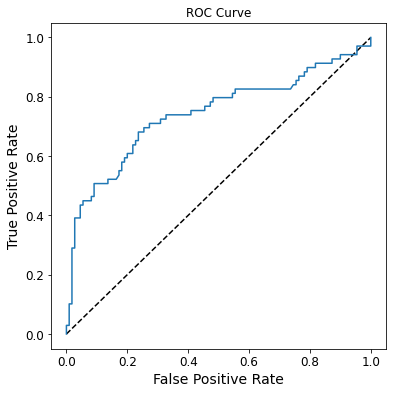

In [40]:
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

# calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

The ROC chart shows the curve of the true and false positive rates for different threshold values between 0 and 1. A perfect classifier would have a curve that goes straight up the left side and straight across the top. The diagonal line across the chart represents the probability of predicting correctly with a 50/50 random prediction; so you obviously want the curve to be higher than that (or your model is no better than simply guessing!).

The area under the curve (AUC) is a value between 0 and 1 that quantifies the overall performance of the model. The closer to 1 this value is, the better the model. Once again, scikit-Learn includes a function to calculate this metric.

In [41]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test,y_scores[:,1])
print('AUC: ' + str(auc))

AUC: 0.7420289855072464


### Criando um pipeline: *preprocessamento* --> *modelo*
***

In [42]:
numeric_features = df.select_dtypes(include=['int64', 'float64']).drop('Survived', axis=1).columns
numeric_features

Index(['Age', 'SibSp', 'Parch', 'Fare', 'family_size'], dtype='object')

In [43]:
categoric_features = df.select_dtypes(include=['category', 'object']).columns
categoric_features

Index(['Pclass', 'Sex', 'Embarked'], dtype='object')

In [44]:
X=df.drop('Survived', axis=1)
y=df['Survived']
# Split data 70%-20% into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

print ('Training cases: %d\nTest cases: %d' % (X_train.shape[0], X_test.shape[0]))

Training cases: 712
Test cases: 179


In [45]:
# Train the model
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np

# Define preprocessing for numeric columns (normalize them so they're on the same scale)
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# Define preprocessing for categorical features (encode the Age column)

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categoric_features)])

# Create preprocessing and training pipeline
logregressor = Pipeline(steps=[('preprocessor', preprocessor),
                           ('logregressor', LogisticRegression(penalty='l2', C=1.0, solver='liblinear'))])


# fit the pipeline to train a logistic regression model on the training set
model = logregressor.fit(X_train, (y_train))
print (model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'SibSp', 'Parch', 'Fare', 'family_size'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Pclass', 'Sex', 'Embarked'], dtype='object'))])),
                ('logregressor', LogisticRegression(solver='liblinear'))])


O pipeline encapsula o passos de preprocessamento e o de  treinamento do modelo.

Confusion Matrix:
 [[96 14]
 [19 50]] 

Accuracy: 0.8156424581005587
Overall Precision: 0.78125
Overall Recall: 0.7246376811594203
AUC: 0.8628458498023716


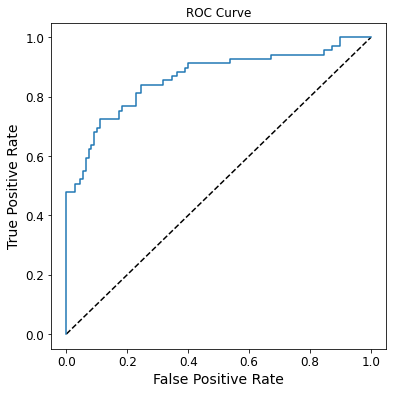

In [46]:
# Get predictions from test data
predictions = model.predict(X_test)
y_scores = model.predict_proba(X_test)

# Get evaluation metrics
cm = confusion_matrix(y_test, predictions)
print ('Confusion Matrix:\n',cm, '\n')
print('Accuracy:', accuracy_score(y_test, predictions))
print("Overall Precision:",precision_score(y_test, predictions))
print("Overall Recall:",recall_score(y_test, predictions))
auc = roc_auc_score(y_test,y_scores[:,1])
print('AUC: ' + str(auc))

# calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [49]:
predictions = model.predict(X_test)
pred_results = pd.DataFrame({'y_test':y_test,
                             'y_pred':predictions})
pred_results.head()

,y_test,y_pred
495,0,0
648,0,0
278,0,0
31,1,1
255,1,1


In [50]:
titanic_crosstab=pd.crosstab(pred_results.y_pred, pred_results.y_test)
titanic_crosstab

y_test,0,1
y_pred,,
0,96,19
1,14,50
